In [1]:
from IPython.display import display, HTML #make wider
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from matplotlib.path import Path
import os

###############################################################################################

def  drop_short_lived(sub_data,mstep):
    # Create a list to store storm data temporarily
    storm_data_temp = []

    for storm_id, storm_d in sub_data.groupby('SID'):
        if len(storm_d) >= mstep:
            storm_data_temp.append(storm_d)

    # Concatenate the list of DataFrames into a new DataFrame
    return pd.concat(storm_data_temp)

##############################################################################################

def count_storms_by_cat(sub_data, cat_level):
    """
    Count the number of unique storms in the dataset that are of a specific category level or above.
    
    Parameters:
    sub_data (pd.DataFrame): DataFrame containing storm data.
    category_level (float): The category level to filter storms.
    
    Returns:
    int: The count of unique storms at the specified category level or above.
    """
    # Filter storms based on category level
    filtered_storms = sub_data[sub_data['UNI_CAT'] >= cat_level]
    
    # Count unique storm IDs (SID)
    storm_count = filtered_storms['SID'].nunique()
    
    return filtered_storms, storm_count 


##############################################################################################

def point_in_polygon(lon, lat, polygon_path):
    return polygon_path.contains_point((lon, lat))

def basin_data(in_df, basin=None):
    
    # Read the dataframe
    df = in_df
    
    # Convert longitude values from [0, 360) to [-180, 180)
    df['LON'] = (df['LON'] + 180) % 360 - 180

    # Check if basin is provided
    if basin is not None:
        # Define the polygon coordinates based on the provided basin
        
        if basin == 'Glb':
            polygon_coords = np.array([[-180, 50], [-180, -50], [180, -50], [180, 50], [-180, 50]])
            
        elif basin == 'NA':
            polygon_coords = np.array([[-70, 0], [-100, 20], [-100, 50], [0, 50], [0, 0], [-70, 0]])
            
        elif basin == 'EP':
            polygon_coords = np.array([[-70, 0], [-100, 20], [-100, 50], [-180, 50], [-180, 0], [-70, 0]])            
            
        elif basin == 'WNP': 
            polygon_coords = np.array([[100, 0], [100, 50], [180, 50], [180, 0], [100, 0]]) 
            
        elif basin == 'NI': 
            polygon_coords = np.array([[30, 0], [30, 50], [100, 50], [100, 0], [30, 0]]) 

        elif basin == 'SI': 
            polygon_coords = np.array([[10, 0], [10, -50], [135, -50], [135, 0], [10, 0]])            

        elif basin == 'SA': 
            polygon_coords = np.array([[10, 0], [10, -50], [-70, -50], [-70, 0], [10, 0]]) 

        elif basin == 'SP':  # this is special case. So, coordinate in 0 to 360 form
            polygon_coords = np.array([[135, 0], [135, -50], [290, -50], [290, 0], [135, 0]]) 

        # Create the polygon path
        polygon_path = Path(polygon_coords)

        # Filter rows based on the condition      
        if basin == 'SP':
            
            # Convert longitude values from [-180, 180] to [0, 360] before applying mask
            df['LON'] = (df['LON'] + 360) % 360 
            
            mask = df.apply(lambda row: point_in_polygon(row['LON'], row['LAT'], polygon_path), axis=1)
            filtered_df = df[mask]
    
            # Convert longitude values from back to [-180, 180]
            filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
            
        else:
            mask = df.apply(lambda row: point_in_polygon(row['LON'], row['LAT'], polygon_path), axis=1)
            filtered_df = df[mask]
            
        return filtered_df
    # If basin is not provided, return the original DataFrame
    return df

################################################################################################

def process_data_subset(sub_data, s_yr, e_yr, mstep, order, cat_level, basin=None):
    # Extract years
    sub_data['YEAR'] = pd.to_datetime(sub_data['ISO_TIME']).dt.year
    
    # Filter data for the selected years
    sub_filt = sub_data[(sub_data['YEAR'] >= s_yr) & (sub_data['YEAR'] <= e_yr)]
    
    # Apply order-specific processing
    if order == 's2b' :
        # Drop short-lived storms
        sub_filt = drop_short_lived(sub_filt, mstep)        
        # Filter data for the basin
        if basin:
            sub_filt = basin_data(sub_filt, basin)
        sub_filt, _ = count_storms_by_cat(sub_filt, cat_level)         # filter by CAT thresolds 

    elif order == 'b2s' :
        # Filter data for the basin
        if basin:
            sub_filt = basin_data(sub_filt, basin)      
        # Drop short-lived storms
        sub_filt = drop_short_lived(sub_filt, mstep)
        sub_filt, _ = count_storms_by_cat(sub_filt, cat_level)         # filter by CAT thresolds 
    
    return sub_filt

###############################################################################################

def annual_count(sub_data, s_yr, e_yr, mstep, order, cat_level, basin=None):
    
    sub_data = process_data_subset(sub_data, s_yr, e_yr, mstep, order, cat_level, basin)
    
    years = range(s_yr, e_yr+1)
    
    # Initialize a 2D array to represent the pivot table 
    pivot_table = np.zeros((len(years)), dtype=int)

    # Iterate through each storm in the experiment dataframe
    for sid, storm_data in sub_data.groupby('SID'):
        # Sort storm data by ISO_TIME
        storm_data = storm_data.sort_values(by='ISO_TIME')
        # Take only the initial timestep of the storm
        initial_timestep = storm_data.iloc[0]['ISO_TIME']
        # Extract year from initial timestep
        year = pd.to_datetime(initial_timestep).year
        # Check if the year is within the defined range
        if year in years:
            # Find index positions for year and month
            year_index = year - s_yr
            # Increment corresponding cell in the pivot table
            pivot_table[year_index] += 1
    
    return pivot_table


def annual_ace_pivot(sub_data, s_yr, e_yr, mstep, order, cat_level, basin=None): #########################
    
    sub_data = process_data_subset(sub_data, s_yr, e_yr, mstep, order, cat_level, basin)
    
    years = range(s_yr, e_yr+1)
    
    # Initialize a 2D array to represent the pivot table 
    pivot_table = np.zeros((len(years)), dtype=int)
    
    # Convert wind speed from m/s to knots
    wind_speed_knots = sub_data['UNI_WIND'] * 1.94384  # 1 m/s = 1.94384 knots
    
    # Calculate the ACE for each time step
    ce = (wind_speed_knots ** 2) * 10**-4  # ACE calculation in knots^2
    
    # Extract year from ISO_TIME
    sub_data['YEAR'] = pd.to_datetime(sub_data['ISO_TIME']).dt.year
    
    # Iterate over each year
    for year, year_group in sub_data.groupby('YEAR'):
        
        wind_values_mps = year_group['UNI_WIND']
        
        if year in years:
            # Find index positions for year 
            year_index = year - s_yr
            # Sum up the ACE values for each year
            pivot_table[year_index] = (wind_values_mps * 1.94384).pow(2).sum() * 10**-4
    
    return ce, pivot_table


############################################################################################

def annual_count_and_ace(sub_data, s_yr, e_yr, mstep, order, cat_level, basin=None):
    
    years = range(s_yr, e_yr + 1)
    
    # Extract the years from the "ISO_TIME" column 
    sub_data['YEAR'] = pd.to_datetime(sub_data['ISO_TIME']).dt.year

    # Filter data for the selected years
    sub_data = sub_data[(sub_data['YEAR'] >= s_yr) & (sub_data['YEAR'] <= e_yr)]
    
    if order == 's2b':
        # Drop short-lived storms
        sub_data = drop_short_lived(sub_data.copy(), mstep)        
        # Filter data for the basin
        exp_df_filtered = basin_data(sub_data, basin)
        exp_df_filtered, _ = count_storms_by_cat(exp_df_filtered, cat_level)
        
    elif order == 'b2s':
        # Filter data for the basin
        sub_data = basin_data(sub_data, basin)      
        # Drop short-lived storms
        exp_df_filtered = drop_short_lived(sub_data.copy(), mstep)        
        exp_df_filtered, _ = count_storms_by_cat(exp_df_filtered, cat_level)
        
    # Initialize pivot tables for counts and ACE
    count_pivot_table = np.zeros((len(years)), dtype=int)
    ace_pivot_table = np.zeros((len(years)), dtype=float)

    # Iterate through each storm in the experiment dataframe
    for sid, storm_data in exp_df_filtered.groupby('SID'):
        # Sort storm data by ISO_TIME
        storm_data = storm_data.sort_values(by='ISO_TIME')
        # Take only the initial timestep of the storm
        initial_timestep = storm_data.iloc[0]['ISO_TIME']
        # Extract year from initial timestep
        year = pd.to_datetime(initial_timestep).year

        if year in years:
            # Find index positions for year
            year_index = year - s_yr
            # Increment corresponding cell in the count pivot table
            count_pivot_table[year_index] += 1
            # Sum the ACE for this storm
            wind_values_mps = storm_data['UNI_WIND']
            ace_pivot_table[year_index] += (wind_values_mps * 1.94384).pow(2).sum() * 10**-4  # Sum ACE values for the storm (m/s to knots conversion)

    return count_pivot_table, ace_pivot_table


In [3]:
# Load observation dataset with exp. settings #######################################################

s_yr = 1998
e_yr = 2007

# Define the step threshold
mstep_ob = 4
mstep_mo = 12

mstep_values = [mstep_mo]

cri = 'SS'

basins = ['Glb', 'NA', 'NI', 'SI', 'SA', 'WNP', 'EP', 'SP']

order = 's2b' # order 's2b' or 'b2s' , drop_short_lived (steps) and then basin; or  basin first then drop_shprt_lived (steps)

cat_level = 1.9 # [1.9, 2.9, 3.9]:[TS, CAT1, CAT2] etc.

# Experiment names
exp_name_1 = 'IB-B22'
exp_name_2 = 'JT+HR'
exp_name_3 = 'f3-L'
exp_name_4 = 'f3-H'
exp_name_5 = 'f3-HH'

exp_dfs = {} # bettere to clean if re-running attemp

# Load your datasets
exp_dfs = {
    exp_name_1 : pd.read_csv('../Data/IBTrACS_[Bourdin2022].csv'), 
    exp_name_2 : pd.read_csv('../Data/IBTrACS_[JTWC+HURDAT].csv'),   
    exp_name_3 : pd.read_csv('../Data/f3L_w15.2_Walsh.csv'),
    exp_name_4 : pd.read_csv('../Data/f3H_w17.1_Walsh.csv'),
    exp_name_5 : pd.read_csv('../Data/f3HH_w17.4_Walsh.csv'),

}

# Initialize dictionaries to store pivot tables and statistics for each experiment and mstep
pivot_tables = {}
ace_yby_tables = {}

# Different line types for each mstep value
line_styles = ['-', ':', '-', '-', '-']

colors = ['black', 'black', 'blue', 'green', 'red']


metrics = {}  # to check by both way [from sklearn.metrics import mean_squared_error;  from scipy.stats import pearsonr ]


/tmp/ipykernel_2022/568139211.py:31: DtypeWarning: Columns (21,66,128,143) have mixed types. Specify dtype option on import or set low_memory=False.
  exp_name_1 : pd.read_csv('../Data/IBTrACS_[Bourdin2022].csv'),
/tmp/ipykernel_2022/568139211.py:32: DtypeWarning: Columns (21,66,128,143) have mixed types. Specify dtype option on import or set low_memory=False.
  exp_name_2 : pd.read_csv('../Data/IBTrACS_[JTWC+HURDAT].csv'),


In [4]:
# Method 1: Using 'annual_ace_pivot' function


Glb

f3-L
PCC: 0.25
p-val: 0.492

f3-H
PCC: 0.11
p-val: 0.761

f3-HH
PCC: 0.36
p-val: 0.304

NA

f3-L
PCC: 0.58
p-val: 0.081

f3-H
PCC: 0.57
p-val: 0.083

f3-HH
PCC: 0.47
p-val: 0.174

NI

f3-L
PCC: 0.06
p-val: 0.859

f3-H
PCC: -0.20
p-val: 0.579

f3-HH
PCC: -0.49
p-val: 0.155

SI

f3-L
PCC: -0.54
p-val: 0.104

f3-H
PCC: 0.40
p-val: 0.254

f3-HH
PCC: -0.22
p-val: 0.540

SA

WNP

f3-L
PCC: 0.90
p-val: 0.000

f3-H
PCC: 0.27
p-val: 0.449

f3-HH
PCC: 0.73
p-val: 0.017

EP

f3-L
PCC: -0.41
p-val: 0.242

f3-H
PCC: 0.20
p-val: 0.589

f3-HH
PCC: 0.40
p-val: 0.253

SP


/tmp/ipykernel_2022/437787502.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_2022/437787502.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
/tmp/ipykernel_2022/437787502.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht


f3-L
PCC: 0.07
p-val: 0.844

f3-H
PCC: 0.07
p-val: 0.842

f3-HH
PCC: -0.57
p-val: 0.087
Figure saved as: ../Figure/09_Accumulated Cyclonic Energy of TCs.pdf


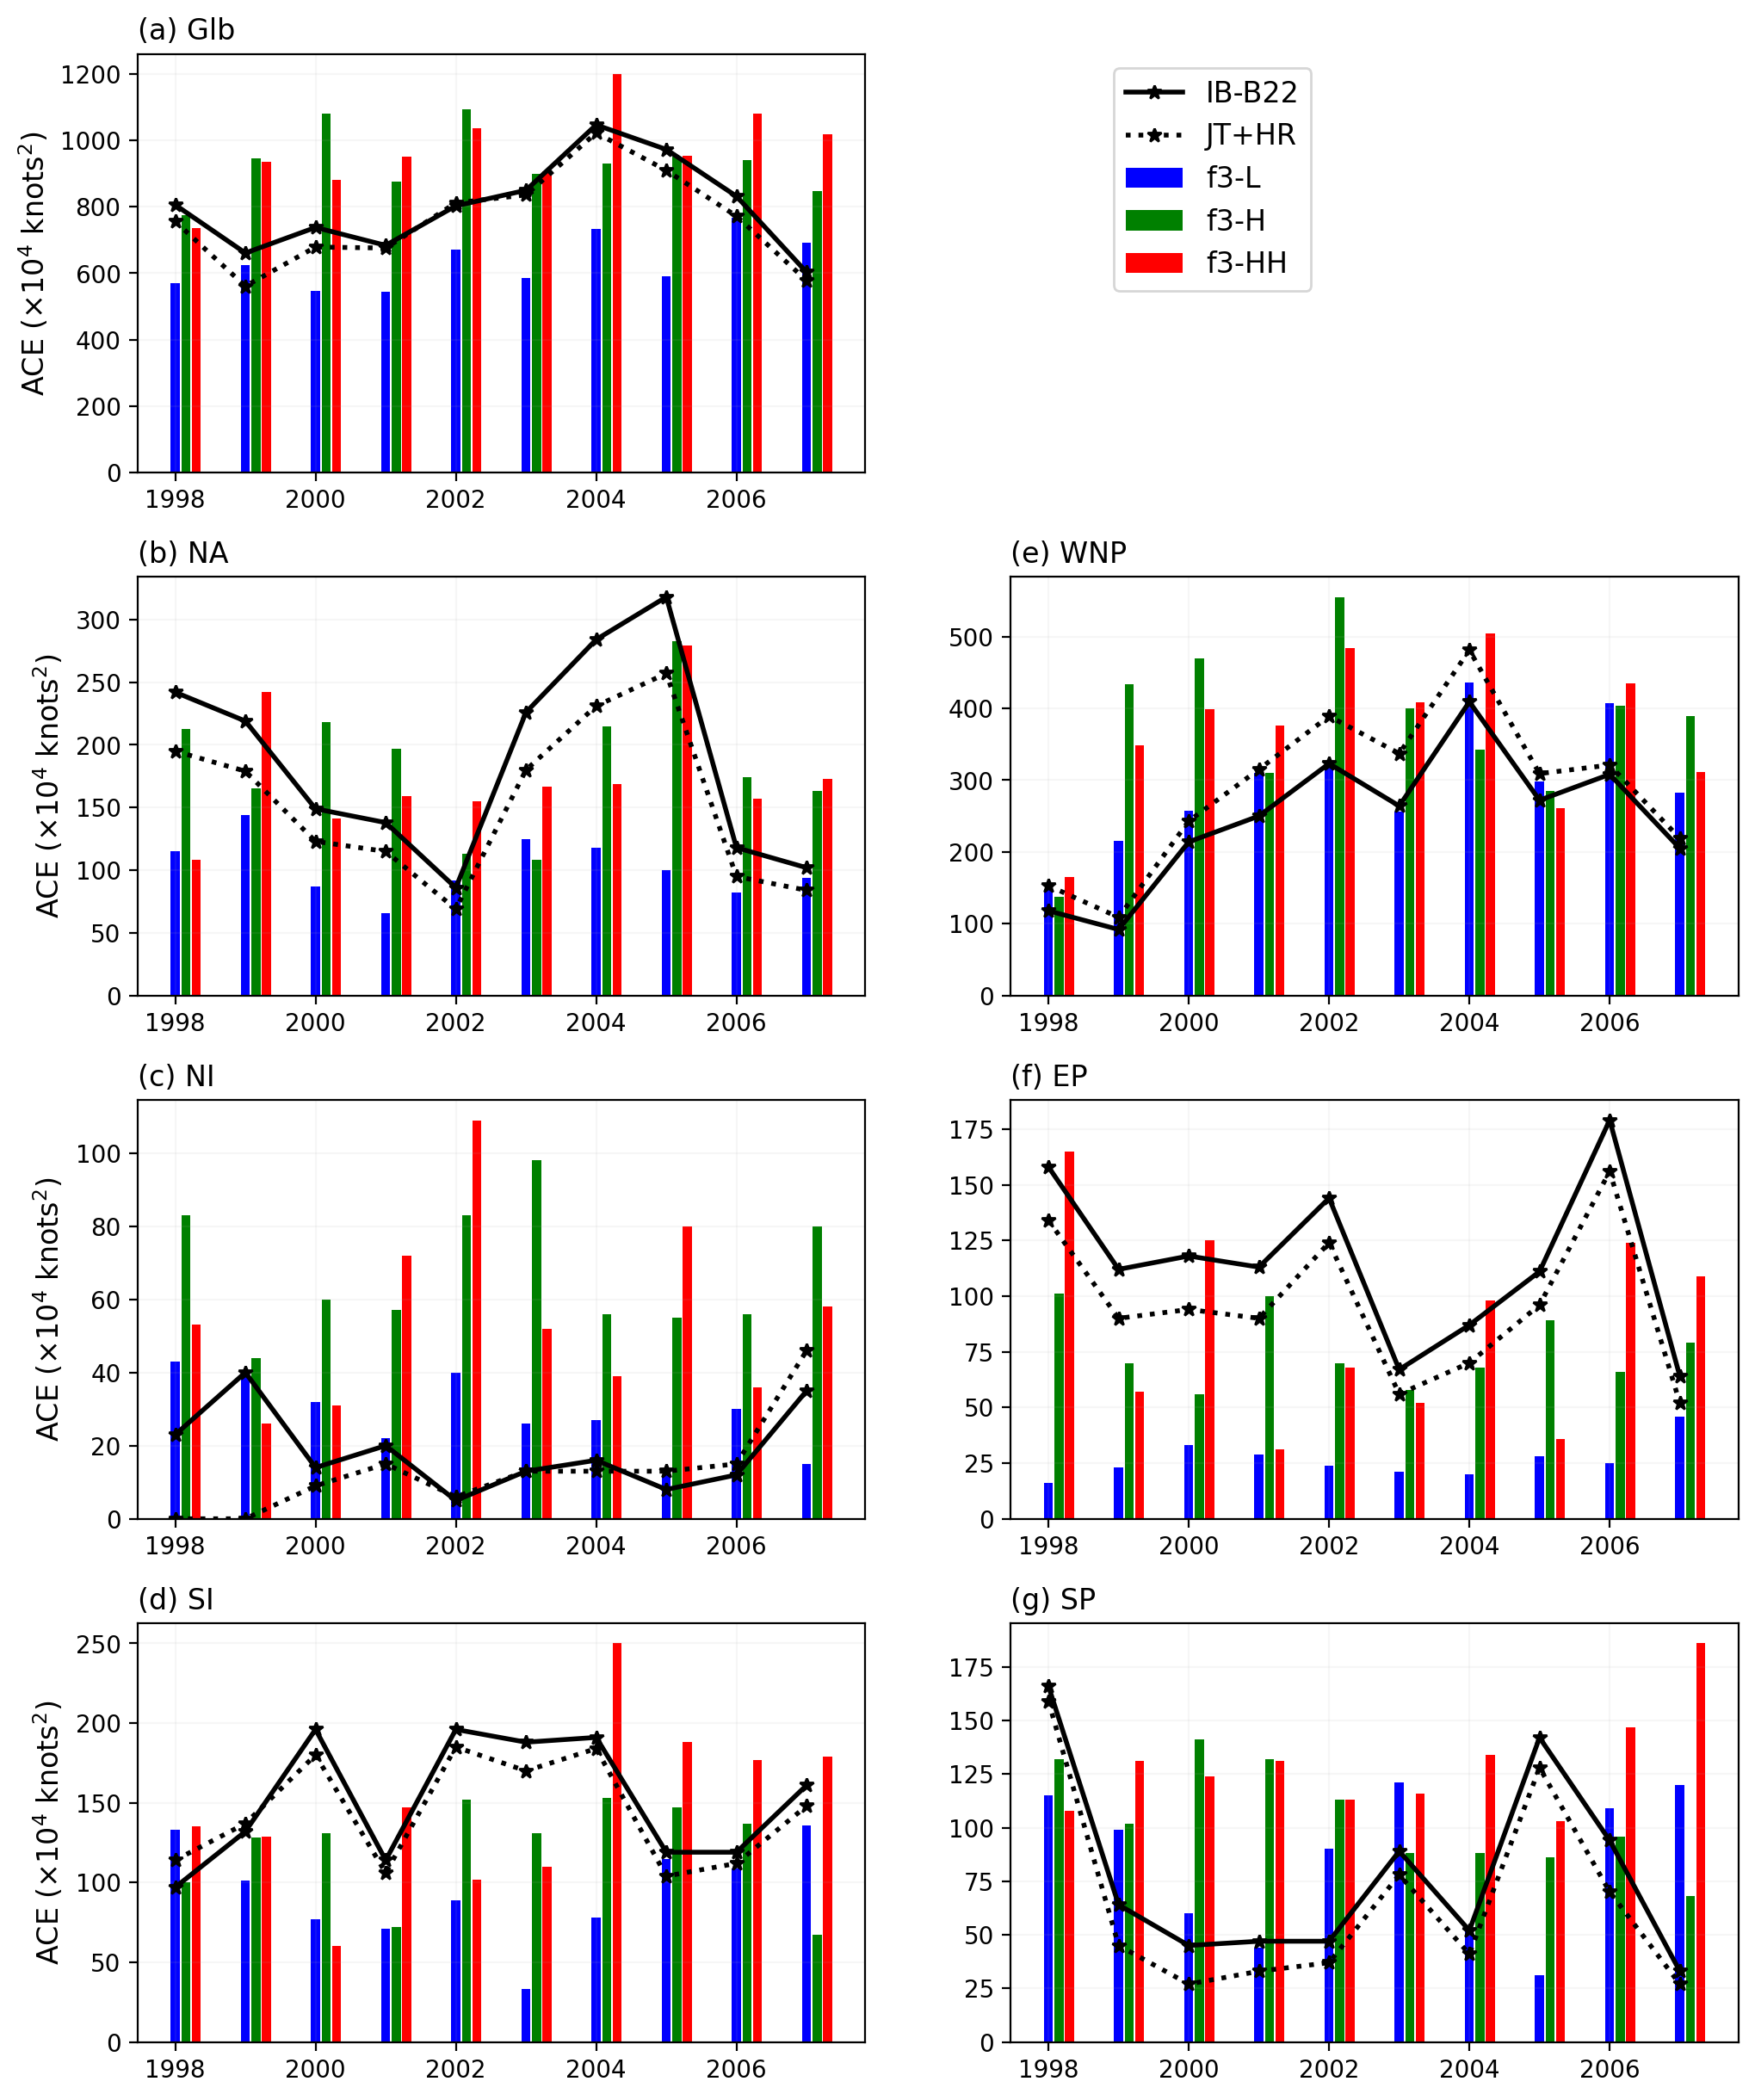

In [5]:
# Create a figure with subplots for each basin
fig, axs = plt.subplots(4, 2, figsize=(12,15))  
fig.set_dpi(200)
labels = ['(a)', '(b)', '(c)', '(d)', '()', '(e)', '(f)', '(g)']

for i, (basin, label) in enumerate(zip(basins, labels)):
    
    print(f'\n{basin}')
    
    if i != 4 :  # Skip subplot 5 (index 4)    
    
        #ax = axs[i//4, i%4 ]  # Select the appropriate subplot
        ax = axs[i%4, i//4 ]  # Select the appropriate subplot

        for idx, (exp_name, exp_df) in enumerate(exp_dfs.items()):
            for mstep_value in mstep_values:
                # Update mstep
                if exp_name==exp_name_1 or exp_name==exp_name_2:
                    mstep = mstep_ob
                else:
                    mstep = mstep_value

                sub_data = exp_df # LOAD DATA

                # call the annual_count() function
                #pivot_table = annual_count(sub_data, s_yr, e_yr, mstep, order, basin)
                ce, pivot_table = annual_ace_pivot(sub_data, s_yr, e_yr, mstep, order, cat_level, basin)
                # Store pivot table and statistics for the experiment and mstep
                pivot_tables[(basin, exp_name, mstep)] = pivot_table
                
                # Plotting the line graph for average monthly storm counts
                if exp_name=='IB-B22' or  exp_name=='JT+HR':
                    ax.plot( range(s_yr, e_yr+1), pivot_table, marker='*', linewidth=2, label=f'{exp_name}', linestyle=line_styles[idx], color=colors[idx])

                else:
                    adjusted_range = [year + 0.15 * idx - 0.30 for inx, year in enumerate(range(s_yr, e_yr+1))]
                    ax.bar( adjusted_range, pivot_table, width=0.13, label=f'{exp_name}', color=colors[idx])  # Plot model data with bars
                      

                # Statistical analysis
                if exp_name != exp_name_1:  # Skip displaying metrics for observation
                    mse_i = mean_squared_error(pivot_tables[(basin, exp_name_1, mstep_ob)], pivot_table)
                    pearson_corr_i, p_val_i = pearsonr(pivot_tables[(basin, exp_name_1, mstep_ob)], pivot_table)
                    metrics[exp_name] = {'MSE': mse_i, 'PCC': pearson_corr_i, 'p-value': p_val_i}        

                del sub_data, mstep_value, mstep, pivot_table


        # Display statistical values
        for exp_name, metrics_i in metrics.items():
            if exp_name != exp_name_1 and exp_name != exp_name_2:  # Skip displaying metrics for observation
                rmse_i = np.sqrt(metrics_i['MSE'])  # Calculate RMSE from MSE
                p_value_i = metrics_i['p-value']  # Get p-value                
                stats_text = f"{exp_name}\nRMSE: {rmse_i:.2f}\nPCC: {metrics_i['PCC']:.2f}\np-val: {p_value_i:.3f}"
                print(f"\n{exp_name}\nPCC: {metrics_i['PCC']:.2f}\np-val: {p_value_i:.3f}")
                #ax.text(0.02, 0.797 - 0.22 * (list(metrics.keys()).index(exp_name) - 1), stats_text, transform=ax.transAxes, fontsize=7, bbox=dict(facecolor='white', alpha=0.3))

        # Display the plot
        # Adding labels and title
        # ax.set_xlabel('Year')
        if (i//4) == 0:
            ax.set_ylabel('Number of TCs', fontsize=12)
            ax.set_ylabel('ACE ($\\times10^4$ knots$^2$)', fontsize=12)

        ax.set_title(f'{label} {basin} ', loc='left')
        #ax.set_ylim(0, 10)

        ax.grid(True, alpha=0.1)
        
# To keep the empty space in the grid for subplot 8, you can use fig.delaxes to remove it
fig.delaxes(axs[0, 1])        

# Create a separate legend outside of the last subplot
handles, labels = ax.get_legend_handles_labels()
ax5 = axs[0, 1]  # Subplot 5
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(ax5.get_position().x1 - 0.20, ax5.get_position().y1) , fontsize=12)  # Adjust the position of the legend

#fig.legend(handles, labels, loc='upper right')
plt.subplots_adjust(hspace=0.25)  # hspace=0.25, Increase vertical spacing between subplots
# Save the figure

os.makedirs('../Figure', exist_ok=True)
save_path = '../Figure/09_Accumulated Cyclonic Energy of TCs.pdf'
plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
print(f"Figure saved as: {save_path}") 

plt.show()

# Now you have pivot tables and statistics for each experiment and mstep stored in respective dictionaries
# You can perform further analysis or visualization as needed
